# Active Contour Model (Snake) Interpolation

In [1]:
import sys
import os

# mengambil path dari project root (menghindari ModuleNotFoundError)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

## Set default parameters & load image

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

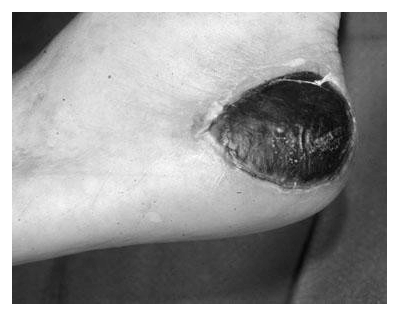

In [2]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

my_dpi = 120 # https://www.infobyip.com/detectmonitordpi.php

cr, cc, rad = 120, 265, 85
sigma, sample = 3.5, 400
alpha, beta, gamma = 0.015, 10, 0.001
max_iter = 800


img_path, img_name, img_extension = "../data/luka_hitam/images", "2", "jpg"
path = f"{img_path}/{img_name}.{img_extension}"

img_groundtruth = rgb2gray(imread("../data/luka_hitam/validation/interpolation/2_region_groundtruth.jpg"))

# get region snake result from existing experiment
existing_result_region = rgb2gray(imread("../data/luka_hitam/validation/interpolation/2_region_result.jpg"))

img = imread(path)
imgray = rgb2gray(img)

img_fig = plt.figure(frameon=False, figsize=(img.shape[1]/my_dpi, img.shape[0]/my_dpi), dpi=my_dpi)
img_ax = img_fig.add_axes([0, 0, 1, 1])
img_ax.imshow(imgray, cmap=plt.cm.gray)
img_ax.set_xticks([]), img_ax.set_yticks([]) # hide axes
img_ax.axis('off')

## Snake Initialization (Circle)

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

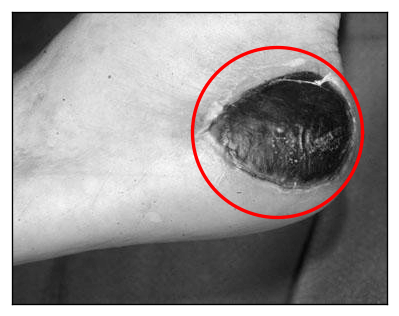

In [3]:
import numpy as np

theta = np.linspace(0, 2*np.pi, sample)
r = cr + rad*np.sin(theta)
c = cc + rad*np.cos(theta)
snake_init = np.array([r, c]).T
snake_xy = snake_init[:, ::-1]
x = snake_xy[:, 0].astype(float)
y = snake_xy[:, 1].astype(float)
snake_len = len(x)

snake_init_fig= plt.figure(frameon=False, figsize=(img.shape[1]/my_dpi, img.shape[0]/my_dpi), dpi=my_dpi)
snake_init_ax = snake_init_fig.add_axes([0, 0, 1, 1])
snake_init_ax.imshow(imgray, cmap=plt.cm.gray)
snake_init_ax.plot(snake_xy[:, 0], snake_xy[:, 1], '-r', lw=2)
snake_init_ax.set_xticks([]), snake_init_ax.set_yticks([])
img_ax.axis('off')

## Energy external

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

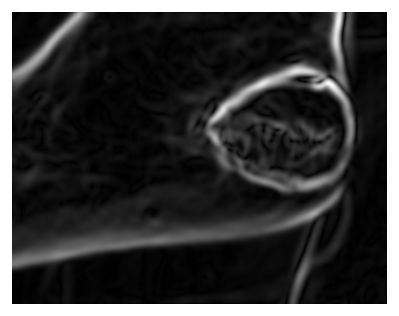

In [4]:
from skimage.filters import gaussian, sobel
from skimage.util import img_as_float

ext = gaussian(imgray, sigma)
ext = img_as_float(ext)
ext = ext.astype(float, copy=False)
ext = sobel(ext)

ext_fig= plt.figure(frameon=False, figsize=(img.shape[1]/my_dpi, img.shape[0]/my_dpi), dpi=my_dpi)
ext_ax = ext_fig.add_axes([0, 0, 1, 1])
ext_ax.imshow(ext, cmap=plt.cm.gray)
ext_ax.set_xticks([]), ext_ax.set_yticks([])
ext_ax.axis('off')

## Energy internal (matrix)

In [5]:
a = beta
b = -(4*beta + alpha)
c = 6*beta + 2*alpha

eye_n = np.eye(snake_len, dtype=float)

c_axis = c * eye_n
b_axis = b * ( np.roll(eye_n, -1, axis=0) + np.roll(eye_n, -1, axis=1) )
a_axis = a * ( np.roll(eye_n, -2, axis=0) + np.roll(eye_n, -2, axis=1) )

A = c_axis + b_axis + a_axis

# Only one inversion is needed for implicit spline energy minimization. skimage
inv = np.linalg.inv(A + gamma * eye_n)
inv = inv.astype(float, copy=False)

inv

array([[34.14224957, 33.97199641, 33.50927443, ..., 32.79828523,
        33.50927443, 33.97199641],
       [33.97199641, 34.14224957, 33.97199641, ..., 31.87950709,
        32.79828523, 33.50927443],
       [33.50927443, 33.97199641, 34.14224957, ..., 30.78982679,
        31.87950709, 32.79828523],
       ...,
       [32.79828523, 31.87950709, 30.78982679, ..., 34.14224957,
        33.97199641, 33.50927443],
       [33.50927443, 32.79828523, 31.87950709, ..., 33.97199641,
        34.14224957, 33.97199641],
       [33.97199641, 33.50927443, 32.79828523, ..., 33.50927443,
        33.97199641, 34.14224957]], shape=(400, 400))

## Deform Snake

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

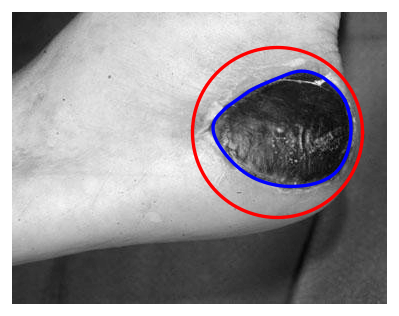

In [6]:
from scipy.interpolate import RectBivariateSpline

gy, gx = np.gradient(ext)

# Interpolate for smoothness
intp_x = RectBivariateSpline(np.arange(gx.shape[1]), np.arange(gx.shape[0]), gx.T, kx=2, ky=2, s=0)

intp_y = RectBivariateSpline(np.arange(gy.shape[1]), np.arange(gy.shape[0]), gy.T, kx=2, ky=2, s=0)

max_px_move=1.0

xt = np.copy(x)
yt = np.copy(y)

for i in range(max_iter):
        # fx & fy
        fx = intp_x(xt, yt, dx=0, grid=False).astype(float, copy=False)
        fy = intp_y(xt, yt, dy=0, grid=False).astype(float, copy=False)
        
        # skimage equation
        xn = np.dot(inv, gamma * xt + fx)
        yn = np.dot(inv, gamma * yt + fy)

        # Movements are capped to max_px_move per iteration. skimage
        dx = max_px_move * np.tanh(xn - xt)
        dy = max_px_move * np.tanh(yn - yt)
        
        xt += dx
        yt += dy

snake_final = np.array([xt, yt]).T


snake_final_fig= plt.figure(frameon=False, figsize=(img.shape[1]/my_dpi, img.shape[0]/my_dpi), dpi=my_dpi)
snake_final_ax = snake_final_fig.add_axes([0, 0, 1, 1])
snake_final_ax.imshow(imgray, cmap=plt.cm.gray)
snake_final_ax.plot(snake_xy[:, 0], snake_xy[:, 1], '-r', lw=2)
snake_final_ax.plot(snake_final[:, 0], snake_final[:, 1], '-b', lw=2)
snake_final_ax.set_xticks([]), snake_final_ax.set_yticks([])
snake_final_ax.axis('off')


## Final Snake region

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

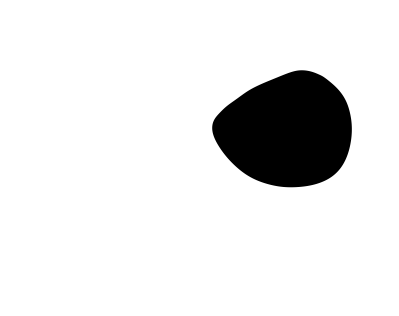

In [7]:
snake_final_region_fig = plt.figure(frameon=False, figsize=(img.shape[1] / my_dpi, img.shape[0] / my_dpi), dpi=my_dpi)
snake_final_region_ax = snake_final_region_fig.add_axes([0, 0, 1, 1])
snake_final_region_ax.imshow(np.ones(img.shape))
snake_final_region_ax.fill(snake_final[:, 0], snake_final[:, 1], color="black")
snake_final_region_ax.set_xticks([]), snake_final_region_ax.set_yticks([])
snake_final_region_ax.axis("off")

## Groundtruth

(np.float64(-0.5), np.float64(374.5), np.float64(291.5), np.float64(-0.5))

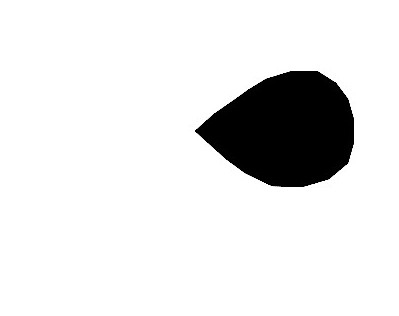

In [8]:
region_groundtruth_fig = plt.figure(frameon=False, figsize=(img_groundtruth.shape[1] / my_dpi, img_groundtruth.shape[0] / my_dpi), dpi=my_dpi)
region_groundtruth_ax = region_groundtruth_fig.add_axes([0, 0, 1, 1])
region_groundtruth_ax.imshow(img_groundtruth, cmap=plt.cm.gray)
region_groundtruth_ax.set_xticks([]), region_groundtruth_ax.set_yticks([])
region_groundtruth_ax.axis('off')

## Region based validation accuracy

(np.float64(-0.5), np.float64(374.5), np.float64(341.5), np.float64(-0.5))

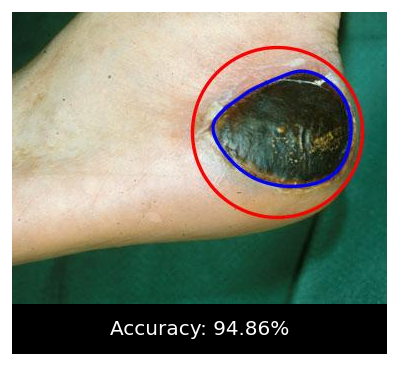

In [9]:
existing_result = imread("../data/luka_hitam/output/interpolation/2.jpg")

sum_gt = 0
sum_int = 0

for x in img_groundtruth:
    for y in x:
        if y != 1.0:
            sum_gt += 1

for p in existing_result_region:
    for q in p:
        if q != 1.0:
            sum_int += 1

accuracy = 100 - abs(sum_gt - sum_int) / sum_gt * 100

bottom_padding = 50
pad_color = 0  # hitam

img_padded = np.pad(existing_result, ((0, bottom_padding), (0, 0), (0, 0)), mode='constant', constant_values=pad_color)

accuracy_fig = plt.figure(
    frameon=False,
    figsize=(img_padded.shape[1]/my_dpi, img_padded.shape[0]/my_dpi),
    dpi=my_dpi
)

accuracy_ax = accuracy_fig.add_axes([0, 0, 1, 1])
accuracy_ax.imshow(img_padded, cmap=plt.cm.gray)

accuracy_ax.text(
    img_padded.shape[1] // 2,
    img_padded.shape[0] - bottom_padding // 2,
    f'Accuracy: {accuracy:.2f}%',
    color='white',
    fontsize=12,
    ha='center',
    va='center',
    bbox=dict(facecolor='black', alpha=0.7)
)

accuracy_ax.set_xticks([]), accuracy_ax.set_yticks([])
accuracy_ax.axis('off')